In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'cs231n/assignment1/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/cs231n/assignment1/cs231n/datasets
/content/drive/My Drive/cs231n/assignment1


# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.


In [5]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.382501
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ As we initialize W close to zero and we didn't update W, the scores will be close to 0. After we pass through softmax function the results will be 1 / #classes. So in this case 0.1. And then we calculate mean of -log(1/ #classes). So the result will be -log0.1



In [11]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -1.152062 analytic: -1.151977, relative error: 3.680221e-05
numerical: 1.528217 analytic: 1.527952, relative error: 8.658245e-05
numerical: 1.674941 analytic: 1.674992, relative error: 1.530906e-05
numerical: 2.789758 analytic: 2.789853, relative error: 1.695728e-05
numerical: -1.330890 analytic: -1.330921, relative error: 1.179894e-05
numerical: 4.088030 analytic: 4.088112, relative error: 1.011402e-05
numerical: 1.325862 analytic: 1.325588, relative error: 1.033639e-04
numerical: -0.626129 analytic: -0.626095, relative error: 2.738240e-05
numerical: -3.586775 analytic: -3.586833, relative error: 8.139983e-06
numerical: 2.500316 analytic: 2.500287, relative error: 5.838357e-06
numerical: 0.199288 analytic: 0.201969, relative error: 6.682651e-03
numerical: -0.136416 analytic: -0.126291, relative error: 3.854071e-02
numerical: 0.385409 analytic: 0.387004, relative error: 2.065598e-03
numerical: 0.718314 analytic: 0.713506, relative error: 3.358172e-03
numerical: 0.535474 anal

In [10]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.382501e+00 computed in 0.114586s
vectorized loss: 2.382194e+00 computed in 0.013619s
Loss difference: 0.000308
Gradient difference: 0.000000


In [13]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 1e-6, 5e-5, 1e-4]
regularization_strengths = [1e1,1e4, 2.5e4, 5e4]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr in learning_rates:
  for rg in regularization_strengths:
    classifier = Softmax()
    classifier.train(X_train, y_train, learning_rate = lr, reg = rg, num_iters = 2000, verbose = True)
    
    train_acc = np.mean(classifier.predict(X_train) == y_train)
    val_acc = np.mean(classifier.predict(X_val) == y_val)

    results[(lr, rg)] = (train_acc, val_acc)

    if val_acc > best_val:
      best_softmax = classifier
      best_val = val_acc
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 2000: loss 6.117723
iteration 100 / 2000: loss 4.180965
iteration 200 / 2000: loss 4.023434
iteration 300 / 2000: loss 3.553971
iteration 400 / 2000: loss 3.621809
iteration 500 / 2000: loss 3.219311
iteration 600 / 2000: loss 3.395643
iteration 700 / 2000: loss 3.268379
iteration 800 / 2000: loss 3.261063
iteration 900 / 2000: loss 3.161901
iteration 1000 / 2000: loss 2.929038
iteration 1100 / 2000: loss 3.124856
iteration 1200 / 2000: loss 2.892733
iteration 1300 / 2000: loss 2.793361
iteration 1400 / 2000: loss 2.946664
iteration 1500 / 2000: loss 2.779139
iteration 1600 / 2000: loss 2.849231
iteration 1700 / 2000: loss 2.662558
iteration 1800 / 2000: loss 2.873173
iteration 1900 / 2000: loss 2.847459
iteration 0 / 2000: loss 316.565583
iteration 100 / 2000: loss 210.519440
iteration 200 / 2000: loss 141.941734
iteration 300 / 2000: loss 95.519828
iteration 400 / 2000: loss 64.489655
iteration 500 / 2000: loss 43.751849
iteration 600 / 2000: loss 29.904842
iteration 70

/content/drive/My Drive/cs231n/assignment1/cs231n/classifiers/softmax.py:89: RuntimeWarning: overflow encountered in exp
  softmax_denomi = np.sum(np.exp(scores), axis = 1)
/content/drive/My Drive/cs231n/assignment1/cs231n/classifiers/softmax.py:93: RuntimeWarning: divide by zero encountered in log
  loss = np.sum( -np.log(softmax) ) / n_samples
/content/drive/My Drive/cs231n/assignment1/cs231n/classifiers/softmax.py:97: RuntimeWarning: divide by zero encountered in true_divide
  intermediate = -  (1 / softmax)
/content/drive/My Drive/cs231n/assignment1/cs231n/classifiers/softmax.py:97: RuntimeWarning: overflow encountered in true_divide
  intermediate = -  (1 / softmax)
/content/drive/My Drive/cs231n/assignment1/cs231n/classifiers/softmax.py:99: RuntimeWarning: overflow encountered in exp
  coeff = -(np.exp(scores) * (softmax_nomi.reshape(n_samples, 1)) ) / (softmax_denomi ** 2).reshape(n_samples, 1)
/content/drive/My Drive/cs231n/assignment1/cs231n/classifiers/softmax.py:99: RuntimeW

iteration 100 / 2000: loss nan
iteration 200 / 2000: loss nan
iteration 300 / 2000: loss nan
iteration 400 / 2000: loss nan
iteration 500 / 2000: loss nan
iteration 600 / 2000: loss nan
iteration 700 / 2000: loss nan
iteration 800 / 2000: loss nan
iteration 900 / 2000: loss nan
iteration 1000 / 2000: loss nan
iteration 1100 / 2000: loss nan
iteration 1200 / 2000: loss nan
iteration 1300 / 2000: loss nan
iteration 1400 / 2000: loss nan
iteration 1500 / 2000: loss nan
iteration 1600 / 2000: loss nan
iteration 1700 / 2000: loss nan
iteration 1800 / 2000: loss nan
iteration 1900 / 2000: loss nan
iteration 0 / 2000: loss 1532.748840
iteration 100 / 2000: loss nan
iteration 200 / 2000: loss nan
iteration 300 / 2000: loss nan
iteration 400 / 2000: loss nan
iteration 500 / 2000: loss nan
iteration 600 / 2000: loss nan
iteration 700 / 2000: loss nan
iteration 800 / 2000: loss nan
iteration 900 / 2000: loss nan
iteration 1000 / 2000: loss nan
iteration 1100 / 2000: loss nan
iteration 1200 / 2000

/content/drive/My Drive/cs231n/assignment1/cs231n/classifiers/softmax.py:90: RuntimeWarning: overflow encountered in exp
  softmax_nomi = np.exp(scores[range(n_samples), list(y)])
/content/drive/My Drive/cs231n/assignment1/cs231n/classifiers/softmax.py:91: RuntimeWarning: invalid value encountered in true_divide
  softmax = softmax_nomi / softmax_denomi
/content/drive/My Drive/cs231n/assignment1/cs231n/classifiers/softmax.py:99: RuntimeWarning: invalid value encountered in multiply
  coeff = -(np.exp(scores) * (softmax_nomi.reshape(n_samples, 1)) ) / (softmax_denomi ** 2).reshape(n_samples, 1)
/content/drive/My Drive/cs231n/assignment1/cs231n/classifiers/softmax.py:100: RuntimeWarning: invalid value encountered in multiply
  coeff[range(n_samples), y] = (softmax_nomi * softmax_denomi - np.exp(2 * scores[range(n_samples), y]) ) / (softmax_denomi ** 2)


iteration 100 / 2000: loss nan
iteration 200 / 2000: loss nan
iteration 300 / 2000: loss nan
iteration 400 / 2000: loss nan
iteration 500 / 2000: loss nan
iteration 600 / 2000: loss nan
iteration 700 / 2000: loss nan
iteration 800 / 2000: loss nan
iteration 900 / 2000: loss nan
iteration 1000 / 2000: loss nan
iteration 1100 / 2000: loss nan
iteration 1200 / 2000: loss nan
iteration 1300 / 2000: loss nan
iteration 1400 / 2000: loss nan
iteration 1500 / 2000: loss nan
iteration 1600 / 2000: loss nan
iteration 1700 / 2000: loss nan
iteration 1800 / 2000: loss nan
iteration 1900 / 2000: loss nan
iteration 0 / 2000: loss 1543.534628
iteration 100 / 2000: loss nan
iteration 200 / 2000: loss nan
iteration 300 / 2000: loss nan
iteration 400 / 2000: loss nan
iteration 500 / 2000: loss nan
iteration 600 / 2000: loss nan
iteration 700 / 2000: loss nan
iteration 800 / 2000: loss nan
iteration 900 / 2000: loss nan
iteration 1000 / 2000: loss nan
iteration 1100 / 2000: loss nan
iteration 1200 / 2000

In [14]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.356000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$


$\color{blue}{\textit Your Explanation:}$



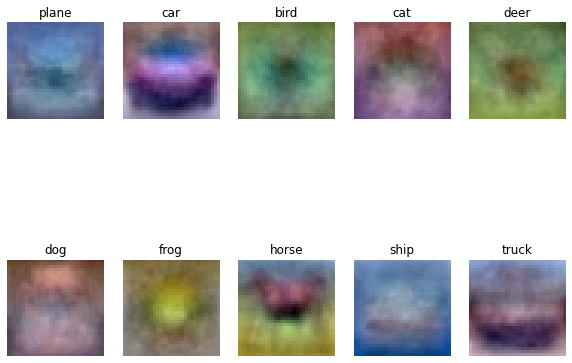

In [15]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])